In [1]:
# HIDE CODE
from dateutil.relativedelta import relativedelta
from joblib import dump, load
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.rcParams.update({'font.size': 12})


import warnings
import sys
import os
sys.path.append('/home/server/gli-data-science/')
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

import os
import ds_db
import helper_db
from helper import transform_to_rupiah, rupiah_format

import pickle
import pandas as pd
import numpy as np

from datetime import datetime, timedelta

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.1f' % x)
pd.options.mode.chained_assignment = None  # default='warn'
from IPython.display import display, HTML, display_html, IFrame
import ipywidgets as ipyw

def side_by_side_display(dfs:list, captions:list):
    output = ""
    combined = dict(zip(captions, dfs))
    styles = [
        dict(selector="caption", props=[("caption-side", "center"), ("font-size", "100%"), ("color", )])]
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline; font-size:85%' ").set_precision(2).set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0\xa0"

    display(HTML(output))

    
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, PoissonRegressor, Ridge, Lasso, RANSACRegressor, RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor, export_text, DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR, SVC, LinearSVC
import xgboost as xgb 


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split


import textwrap
def split_label(list_label):
    list_label = list(list_label)
    list_label = ["<br>".join(textwrap.wrap(t, width=12)) for t in list_label ]
    return list_label

### ide kasar
> 
* daily job to loop all member alfagift 10 juta
* compute feature trx voucher used, # of trx, # of sales
* compute feature event app site open / view product / atc
* updating each feature and re predict churn feature
* lets play in month - 3 for each define trx and event feature

In [2]:
df_pv_ = pd.read_csv('./pv_31Dec21.csv')
df_pv_['EVENT_TIME'] = pd.to_datetime(df_pv_['EVENT_TIME']).dt.strftime('%Y-%m')

df_pv = df_pv_.groupby(['TRO_MEMBERS','EVENT_TIME']).agg(PV=('COUNT_VIEW_PRODUCT','sum'))\
        .unstack(level=1).fillna(0).reset_index()

df_pv.columns = [' '.join(col).strip().upper() for col in df_pv.columns.values]
df_pv = df_pv.drop(['PV 2021-08'], 1)

In [3]:
df_re_g_u = pd.read_csv('./rating_2022-01-01.csv')
df_re_g_u = df_re_g_u.drop(['RATING_BELOW 2021-08', 'RATING_AVG 2021-08'],1)

In [4]:
# HIDE CODE

## USING ORDER
import glob

df_tto = []
for end_date in pd.date_range('2021-08-01', '2022-01-01', freq='M'):
    start_date = end_date.replace(day=1)
    end_date_save = start_date + relativedelta(months=1)
    
    start_date_str = start_date.strftime('%d%b%y')
    end_date_str = end_date_save.strftime('%d%b%y')
    
    print(start_date_str, end_date_str)
    
    pf = '/home/server/gli-data-science/data/trans_oshop_test/{}_{}.csv'.format(start_date_str, end_date_str)
    df_tto.append(pd.read_csv(pf, sep='\t', dtype='object'))
    
df_tto = pd.concat(df_tto)

df_tto = df_tto[df_tto['TRO_MEMBERS'] != 'N']
df_tto['TRO_DATE'] = pd.to_datetime(df_tto['TRO_DATE'])
df_tto['TRO_NET'] = df_tto['TRO_NET'].astype('float', errors='ignore').astype('int', errors='ignore')


df_tto['TRO_QTY'] = df_tto['TRO_QTY'].astype(int)

01Aug21 01Sep21
01Sep21 01Oct21
01Oct21 01Nov21
01Nov21 01Dec21
01Dec21 01Jan22


In [5]:
df_tto['TRO_VOUCHER_USAGE'] = df_tto['TRO_VOUCHER_USAGE'].astype('float', errors='ignore').astype('int', errors='ignore')
#df_tto['TRO_DATE_MONTH'] = df_tto['TRO_DATE'].dt.strftime('%Y-%m')
df_tto['TRO_DH_SPESIAL'] = df_tto['TRO_DH_SPESIAL'].astype('float', errors='ignore').astype('int', errors='ignore')


df_tto_sel = df_tto[(df_tto['TRO_DATE'] >= '2021-09-01') \
            & (df_tto['TRO_DATE'] <= '2021-12-31')]

In [6]:
df_sla = pd.read_csv('./sla_31Dec21.csv')
df_sla['ATT_SEND_DATE_TOSTORE'] = pd.to_datetime(df_sla['ATT_SEND_DATE_TOSTORE'])
df_sla['SLA'] = np.where(df_sla['SLA_NORM']< 0, 20, df_sla['SLA_NORM'])

df_tto_sel = pd.merge(df_tto_sel, df_sla, left_on='TRO_NO_ORDER', right_on='ATT_ORDER_ID', how='left')
df_tto_sel = df_tto_sel.drop(['ATT_ORDER_ID','ATT_ORDER_DATE','ATT_DELIVERY_DATE','ATT_SEND_DATE_TOSTORE','SLA_NORM'],1)

## create feature
df_tto_sel['SLA'] = df_tto_sel['SLA'].fillna(20)
df_tto_sel['SLA_LATE'] = np.where(df_tto_sel['SLA'] > 60, 1,0)

In [7]:
df_mem_push = df_tto_sel[['TRO_MEMBERS']].drop_duplicates()
from sqlalchemy import event,create_engine,types



driver = 'cx_oracle'
server = '10.234.152.61' 
database = 'alfabi' 
username = 'report' 
password = 'justd0it'
engine_stmt = "oracle://%s:%s@%s/%s" % (username, password, server, database )

engine = create_engine(engine_stmt)

df = df_mem_push.astype(str)
dtyp = {c:types.VARCHAR(df[c].str.len().max()) for c in df.columns[df.dtypes == 'object'].tolist()}
df.to_sql('temp_churn', engine, index=False, if_exists="replace", dtype=dtyp)

engine.dispose()





In [8]:
q = '''
SELECT 
	tc.TRO_MEMBERS, 
	(TO_DATE('2021/12/07', 'yyyy/mm/dd')) - zt.tgl_registrasi AS SINCE_REGIS
FROM 
	TEMP_CHURN tc
LEFT JOIN (
	select 
		char1 no_member, char4 jenis_kelamin, char5 status_nikah, date1 tgl_lahir, date2 tgl_registrasi
	from 
		report.ztampungan
	where 
		pk='MEMBERALFAGIFT2'
) zt ON zt.no_member = tc.TRO_MEMBERS 

'''

con = ds_db.connect_alfabi()

df_regis = pd.read_sql_query(q, con)

con.close()

You are connected


In [9]:
df_regis['SINCE_REGIS'] = df_regis['SINCE_REGIS'].fillna('-1')

In [10]:
df_tto_sel_g = df_tto_sel.groupby(['TRO_MEMBERS','TRO_DATE_MONTH','TRO_NO_ORDER'])\
                        .agg({'TRO_NET':'sum',
                              'TRO_DH_SPESIAL':'sum',
                              'TRO_NO_ORDER':'nunique',
                              'SLA':'first',
                              'SLA_LATE':'first',
                              'TRO_VOUCHER_USAGE':'sum',
                              'TRO_PAYMENT_METHOD':'first'
                              ''
                             })
df_tto_sel_g = df_tto_sel_g.groupby(['TRO_MEMBERS','TRO_DATE_MONTH'])\
                        .agg({'TRO_NET':'sum',
                              'TRO_DH_SPESIAL':'sum',
                              'TRO_NO_ORDER':'sum',
                              'SLA':'sum',
                              'SLA_LATE':'sum',
                              'TRO_VOUCHER_USAGE':'sum',
                              'TRO_PAYMENT_METHOD':'nunique'
                             })

## untack all feature in oshop

In [11]:
df_tto_sel_g_u = df_tto_sel_g.unstack(level=1).fillna(0).reset_index()
df_tto_sel_g_u.columns = [' '.join(col).strip().upper() for col in df_tto_sel_g_u.columns.values]

## merge with rating

In [29]:
df_re_g_u['TRO_MEMBERS'] = df_re_g_u['TRO_MEMBERS'].astype(str)
df_tto_re = pd.merge(df_tto_sel_g_u, df_re_g_u, on='TRO_MEMBERS', how='left').fillna(0)

## merge with product view

In [30]:
df_pv['TRO_MEMBERS'] = df_pv['TRO_MEMBERS'].astype(str)
df_tto_re_pv = pd.merge(df_tto_re, df_pv, on='TRO_MEMBERS', how='left').fillna(0)

## merge with regis

In [31]:
df_tto_re_pv = pd.merge(df_tto_re_pv, df_regis, on='TRO_MEMBERS')
df_tto_re_pv = df_tto_re_pv[df_tto_re_pv['SINCE_REGIS'].astype(int) > 0]

In [32]:
df_tto_re_pv['NET 11-10'] = df_tto_re_pv['TRO_NET 2021-11'] - df_tto_re_pv['TRO_NET 2021-10']
df_tto_re_pv['NET 10-09'] = df_tto_re_pv['TRO_NET 2021-10'] - df_tto_re_pv['TRO_NET 2021-09']
df_tto_re_pv['NET 11-09'] = df_tto_re_pv['TRO_NET 2021-11'] - df_tto_re_pv['TRO_NET 2021-09']

df_tto_re_pv['STRUK 11-10'] = df_tto_re_pv['TRO_NO_ORDER 2021-11'] - df_tto_re_pv['TRO_NO_ORDER 2021-10']
df_tto_re_pv['STRUK 10-09'] = df_tto_re_pv['TRO_NO_ORDER 2021-10'] - df_tto_re_pv['TRO_NO_ORDER 2021-09']
df_tto_re_pv['STRUK 11-09'] = df_tto_re_pv['TRO_NO_ORDER 2021-11'] - df_tto_re_pv['TRO_NO_ORDER 2021-09']

df_tto_re_pv['PV 11-10'] = df_tto_re_pv['PV 2021-11'] - df_tto_re_pv['PV 2021-10']
df_tto_re_pv['PV 10-09'] = df_tto_re_pv['PV 2021-10'] - df_tto_re_pv['PV 2021-09']
df_tto_re_pv['PV 11-09'] = df_tto_re_pv['PV 2021-11'] - df_tto_re_pv['PV 2021-09']

df_tto_re_pv['SLA 11-10'] = df_tto_re_pv['SLA 2021-11'] - df_tto_re_pv['SLA 2021-10']
df_tto_re_pv['SLA 10-09'] = df_tto_re_pv['SLA 2021-10'] - df_tto_re_pv['SLA 2021-09']
df_tto_re_pv['SLA 11-09'] = df_tto_re_pv['SLA 2021-11'] - df_tto_re_pv['SLA 2021-09']

In [33]:
# print(df_ins[df_ins['label'] == 1]['NET_11-10'].median())
# print(df_ins[df_ins['label'] == 1]['NET_10-09'].median())
# print(df_ins[df_ins['label'] == 1]['NET_11-09'].median())
# print(df_ins[df_ins['label'] == 1]['STRUK_11-10'].mean())
# print(df_ins[df_ins['label'] == 1]['STRUK_10-09'].mean())
# print(df_ins[df_ins['label'] == 1]['STRUK_11-09'].mean())

## PCA Explained

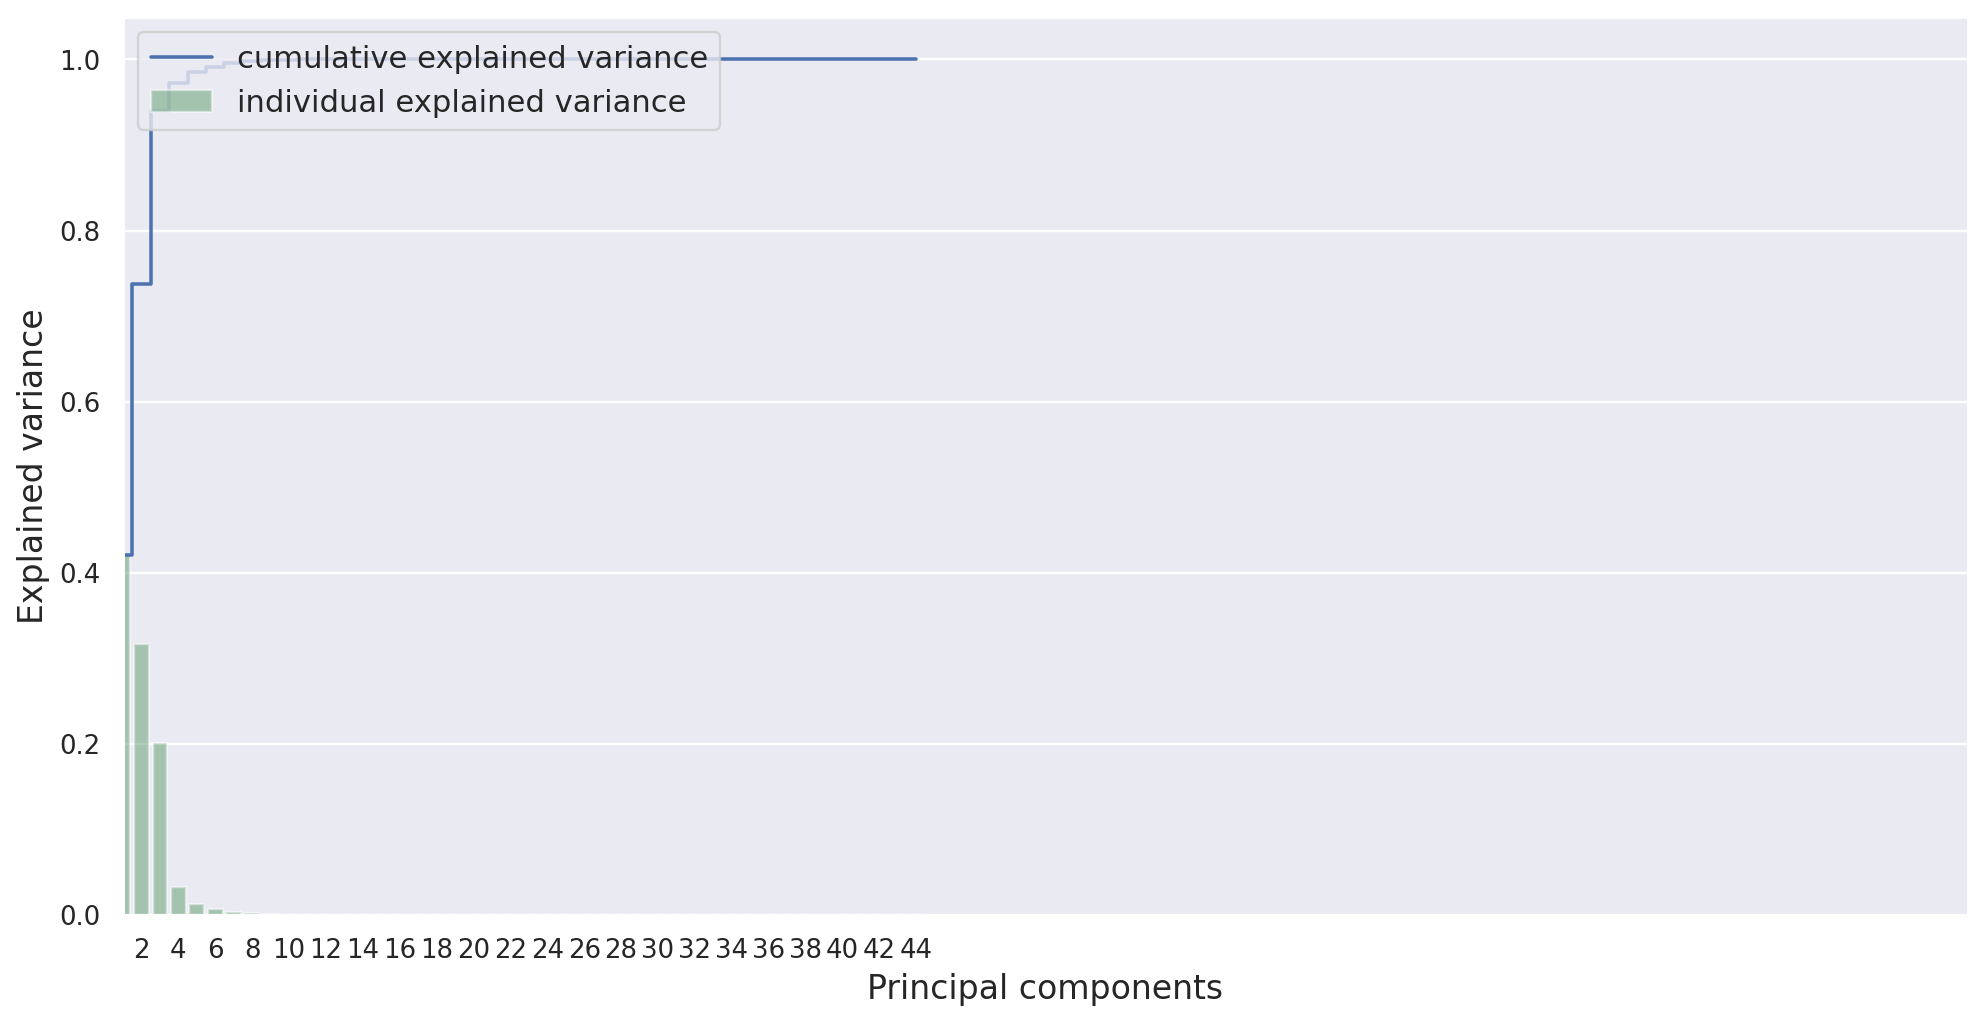

In [34]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]
matrix = X.iloc[:,0:].copy()
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

fig, ax = plt.subplots(figsize=(14, 7), dpi=170)
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

## Hist Boosting

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     96117
           1       0.54      0.14      0.22      8523

    accuracy                           0.92    104640
   macro avg       0.74      0.57      0.59    104640
weighted avg       0.90      0.92      0.90    104640

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     96117
           1       0.58      0.09      0.16      8522

    accuracy                           0.92    104639
   macro avg       0.76      0.54      0.56    104639
weighted avg       0.90      0.92      0.89    104639

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     96116
           1       0.45      0.18      0.26      8523

    accuracy                           0.92    104639
   macro avg       0.69      0.58      0.61    104639
weighted avg       0.89      0.92      0.90    104639

              preci

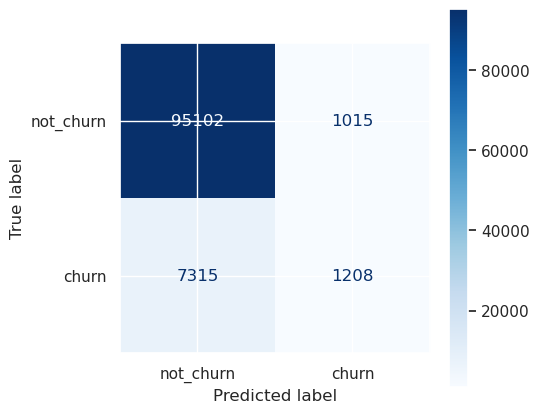

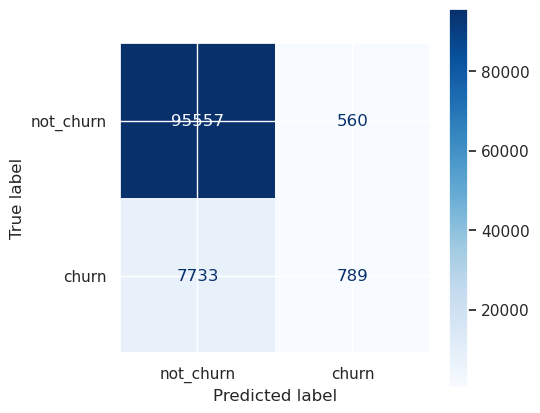

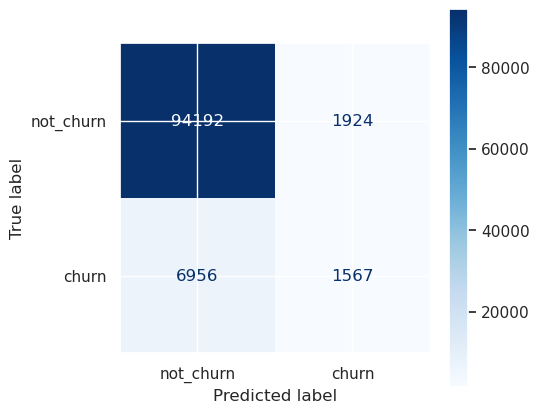

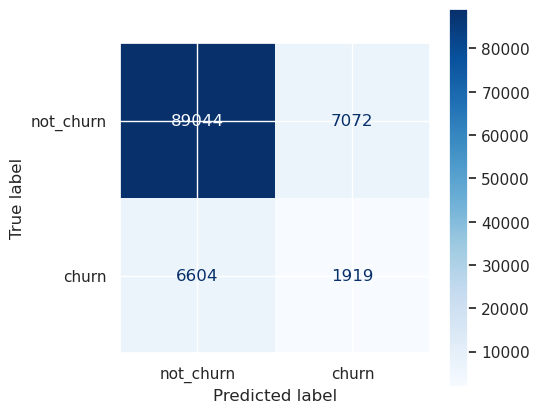

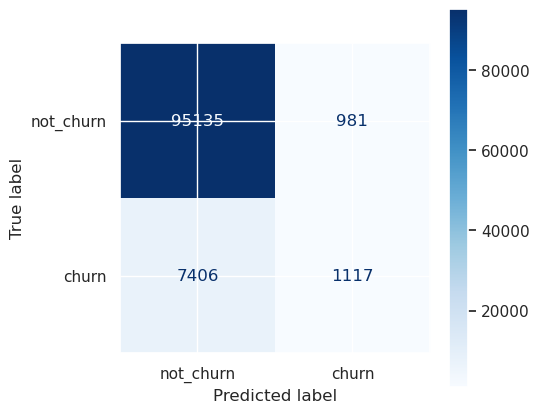

In [35]:
from sklearn.ensemble import HistGradientBoostingClassifier


from sklearn.model_selection import StratifiedKFold
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_DH_SPESIAL 2021-12',
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]



skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    print("="*50)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    
    ## applying standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)
    


    clf_ridge = HistGradientBoostingClassifier()
    clf_ridge.fit(X_train, y_train) 
    pred = clf_ridge.predict(X_test)

    print(classification_report(y_test, pred))
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                            cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                            ax = ax, values_format = 'd')



## Random Forest

### not oversampling version without threshold 2/3

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     96117
           1       0.50      0.16      0.24      8523

    accuracy                           0.92    104640
   macro avg       0.71      0.57      0.60    104640
weighted avg       0.89      0.92      0.90    104640

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     96117
           1       0.53      0.13      0.21      8522

    accuracy                           0.92    104639
   macro avg       0.73      0.56      0.58    104639
weighted avg       0.90      0.92      0.90    104639

              precision    recall  f1-score   support

           0       0.93      0.98      0.96     96116
           1       0.49      0.19      0.28      8523

    accuracy                           0.92    104639
   macro avg       0.71      0.59      0.62    104639
weighted avg       0.90      0.92      0.90    104639

              preci

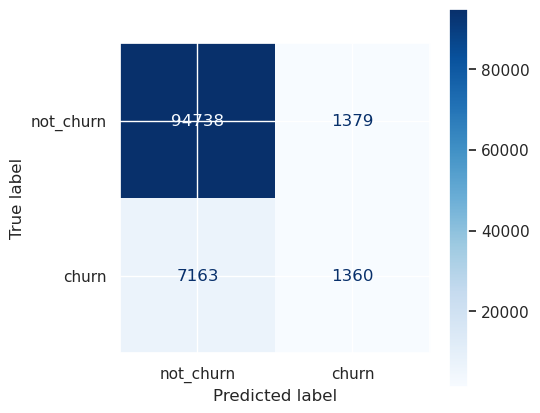

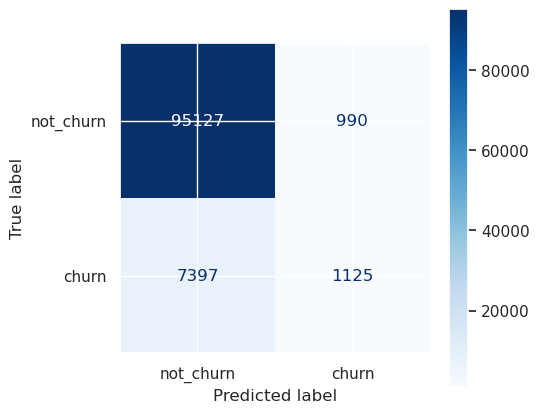

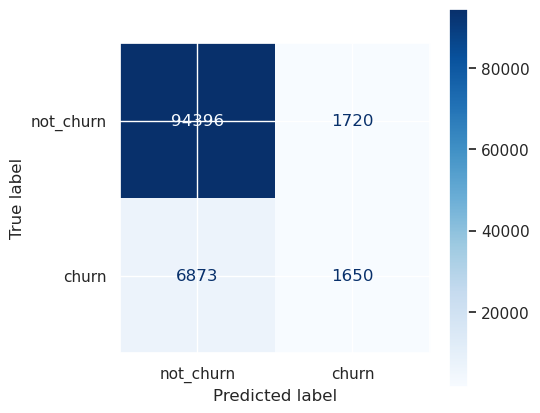

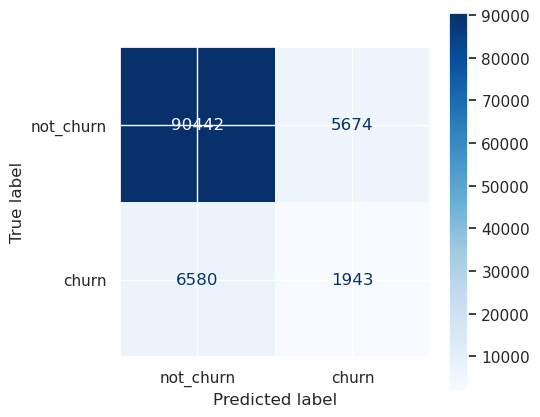

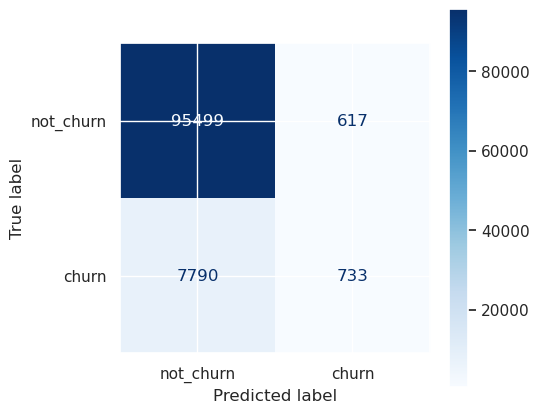

In [36]:
from sklearn.model_selection import StratifiedKFold
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_DH_SPESIAL 2021-12',
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]



skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    print("="*50)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)
    
    ## applying standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)
    

#     ## applying pca
#     n_comp = 5

#     pca = PCA(n_components=n_comp)
#     pca.fit(X_train)
#     X_train = pd.DataFrame(pca.transform(X_train), columns=(['col{}'.format(i) for i in range(1,n_comp+1)]))
#     X_test = pd.DataFrame(pca.transform(X_test), columns=(['col{}'.format(i) for i in range(1,n_comp+1)]))

    clf_ridge = RandomForestClassifier(random_state=42) 
#     clf_ridge = LinearSVC(C=0.01, penalty="l1", dual=False)
    clf_ridge.fit(X_train, y_train) 
    pred = clf_ridge.predict(X_test)
#     pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
    print(classification_report(y_test, pred))
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                            cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                            ax = ax, values_format = 'd')



In [ ]:
df_tto_re_pv[df_tto_re_pv['label'] == 1].head(50)

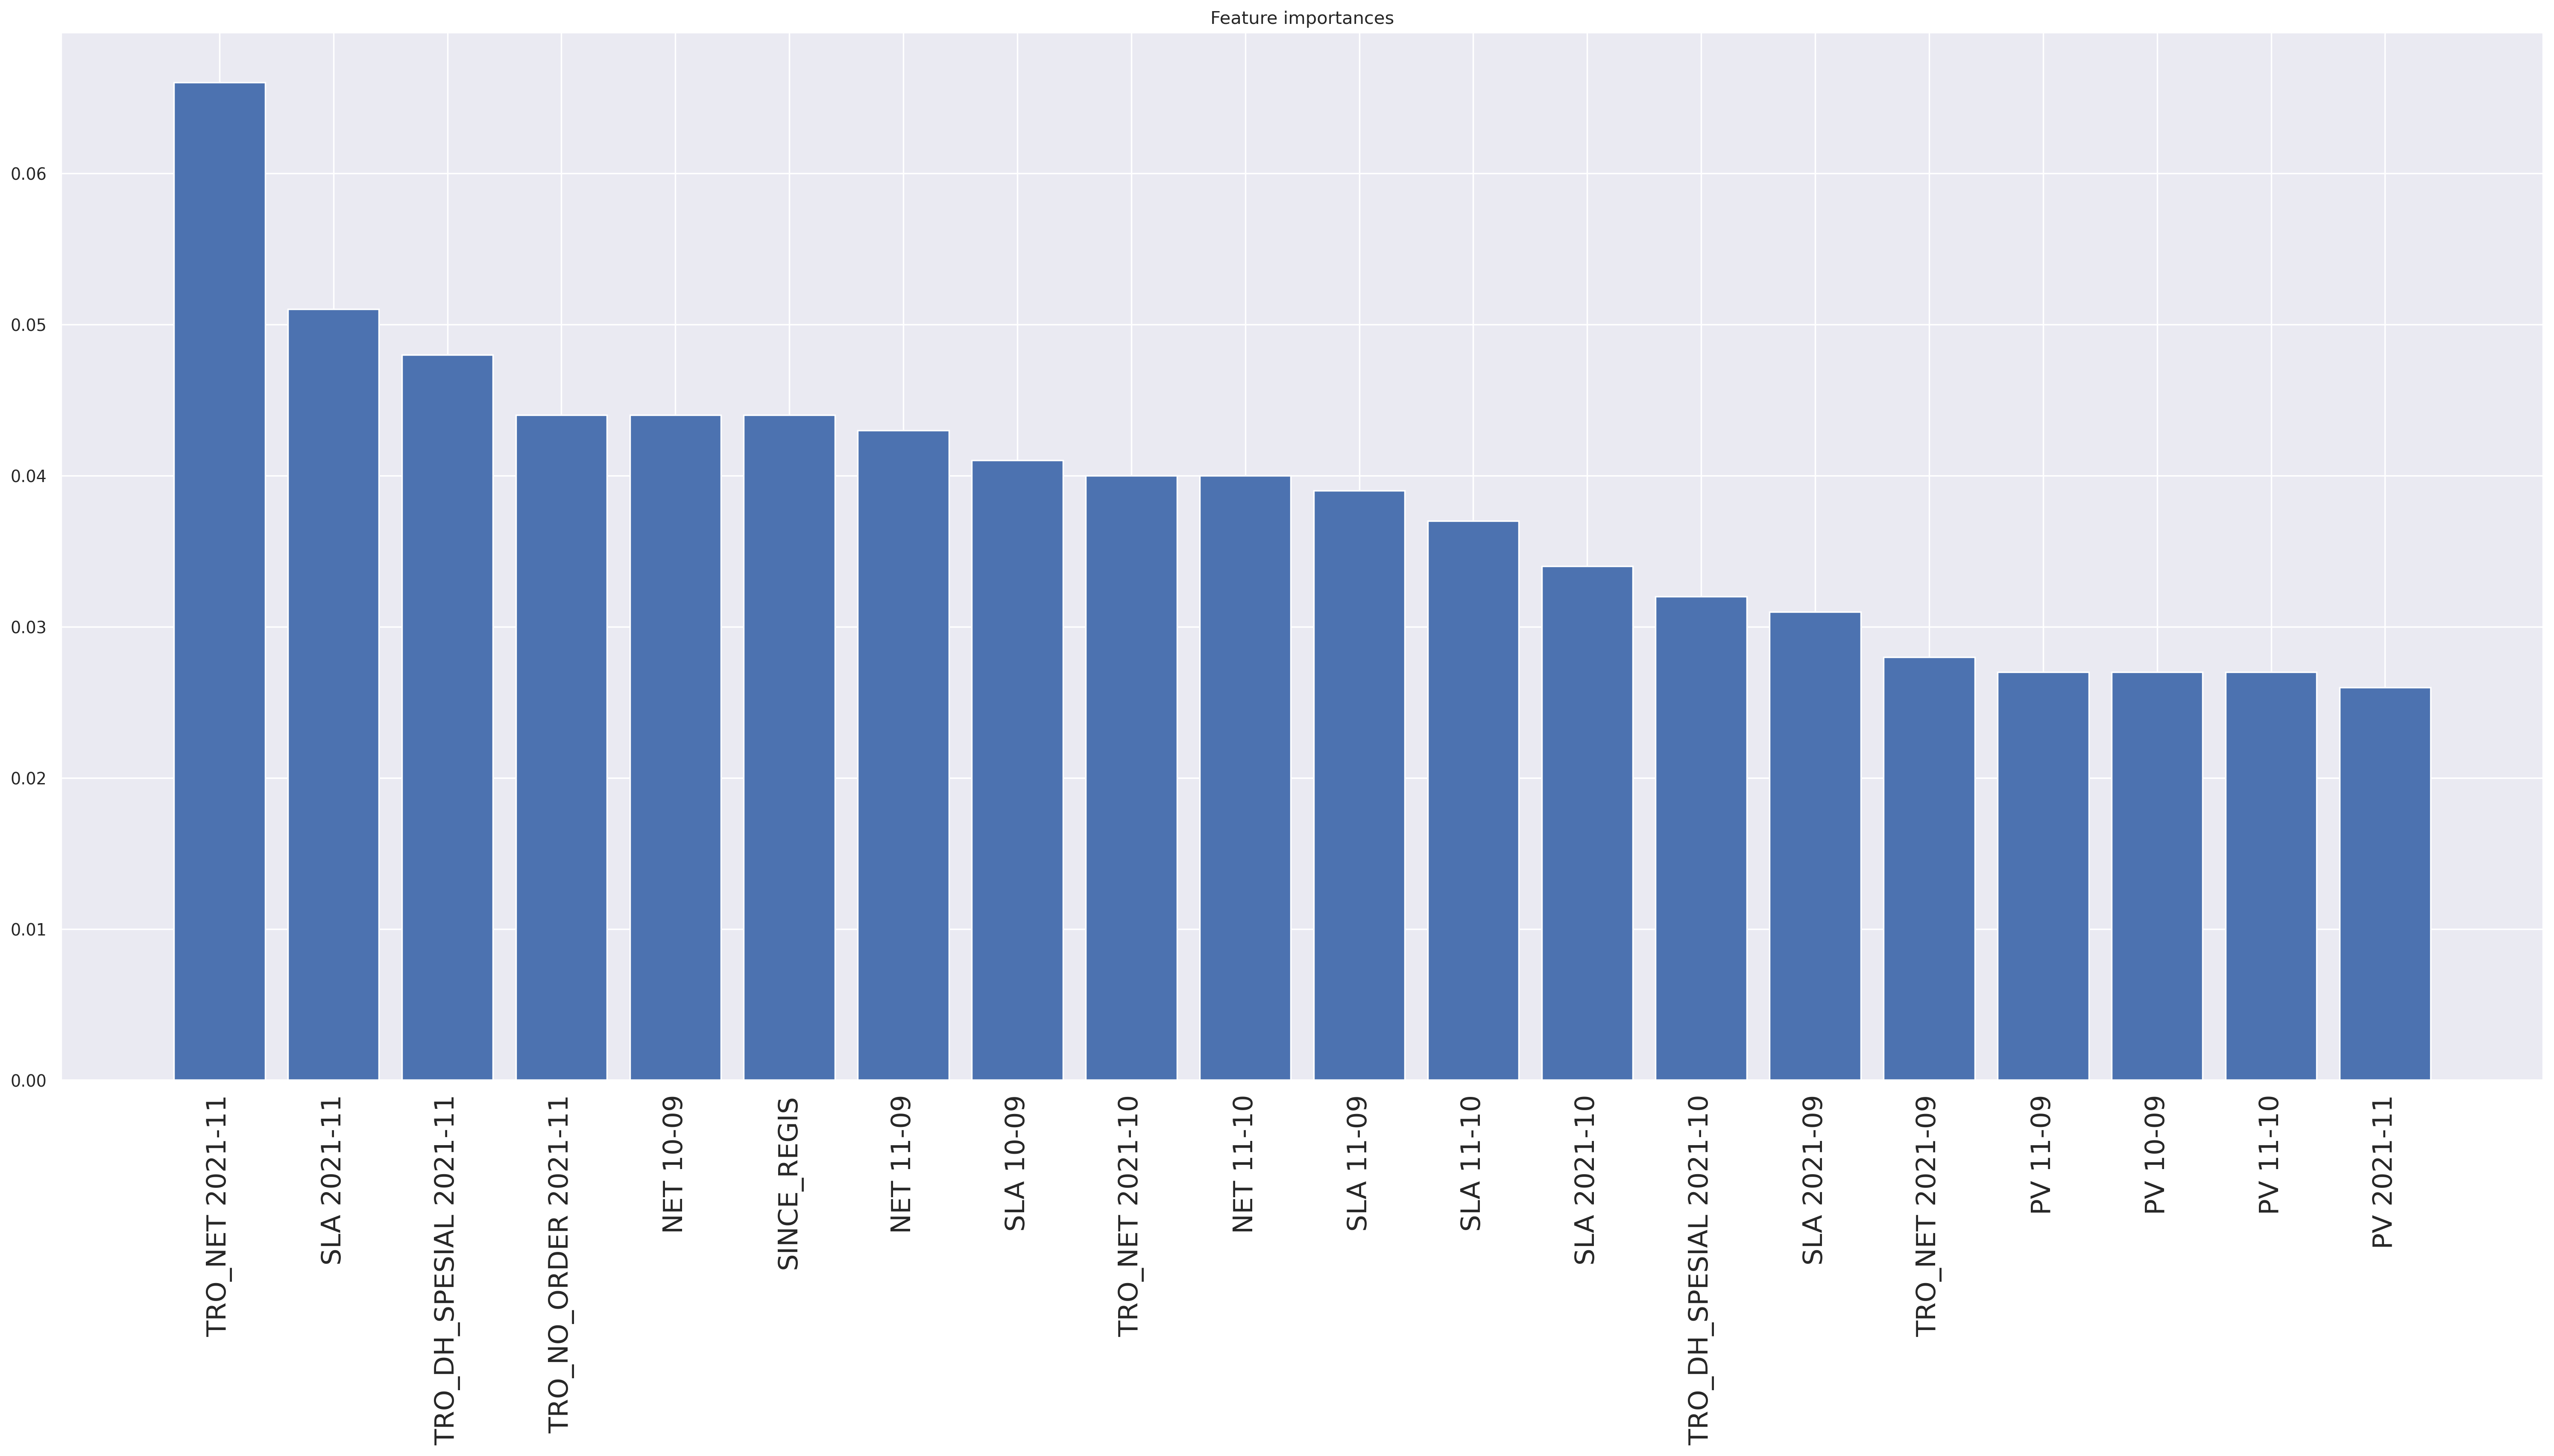

In [37]:
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(clf_ridge.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances = importances[0:20]
x_range = list(range(importances.shape[0]))
x_plot = list(importances.index)
y_plot = list(importances["importance"])
plt.figure(figsize=(30,13), dpi=250)
plt.title("Feature importances")
plt.bar(x_range, y_plot)
plt.xticks(x_range, x_plot, rotation='vertical', fontsize=18)
fig = plt.gcf()


### not oversampling version without threshold 3/3

In [ ]:
condition_3_3 = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition_3_3, 1, 0)

X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_DH_SPESIAL 2021-12',
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)

clf_ridge = RandomForestClassifier(random_state=42) 
clf_ridge.fit(X_train, y_train) 
# pred_proba = clf_ridge.predict_proba(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

In [ ]:
df_res = pd.concat([
    pd.concat([df_tto_re_pv.drop(['label'],1).loc[X_test.index, :].reset_index(drop=True), pd.DataFrame({'pred':pred})],1), 
    y_test.reset_index(drop=True)],1)

In [ ]:
df_res[(df_res['label'] == 0) & (df_res['pred'] == 1)].head(10)

In [ ]:
df_res[(df_res['label'] == 1) & (df_res['pred'] == 0)].head(10)

### rf oversampling version 2/3

              precision    recall  f1-score   support

           0       0.95      0.93      0.94     96117
           1       0.40      0.49      0.44      8523

    accuracy                           0.90    104640
   macro avg       0.67      0.71      0.69    104640
weighted avg       0.91      0.90      0.90    104640



              precision    recall  f1-score   support

           0       0.95      0.95      0.95     96117
           1       0.44      0.46      0.45      8522

    accuracy                           0.91    104639
   macro avg       0.70      0.70      0.70    104639
weighted avg       0.91      0.91      0.91    104639



              precision    recall  f1-score   support

           0       0.96      0.93      0.94     96116
           1       0.39      0.52      0.45      8523

    accuracy                           0.90    104639
   macro avg       0.67      0.72      0.70    104639
weighted avg       0.91      0.90      0.90    104639



              precision    recall  f1-score   support

           0       0.96      0.89      0.92     96116
           1       0.32      0.57      0.41      8523

    accuracy                           0.87    104639
   macro avg       0.64      0.73      0.67    104639
weighted avg       0.91      0.87      0.88    104639



              precision    recall  f1-score   support

           0       0.93      0.98      0.96     96116
           1       0.52      0.22      0.30      8523

    accuracy                           0.92    104639
   macro avg       0.73      0.60      0.63    104639
weighted avg       0.90      0.92      0.90    104639



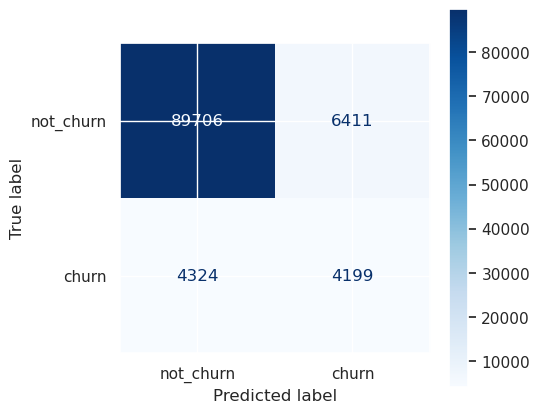

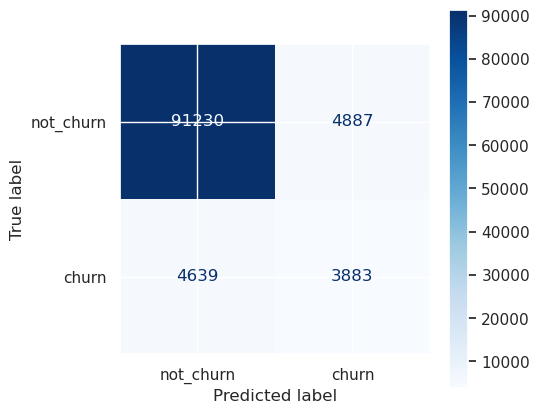

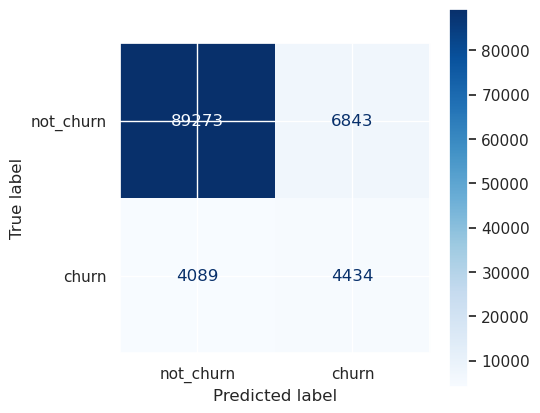

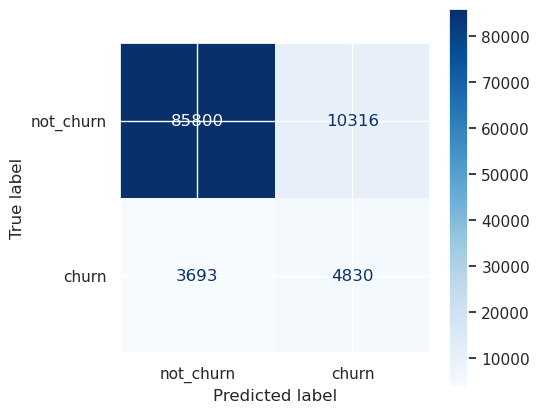

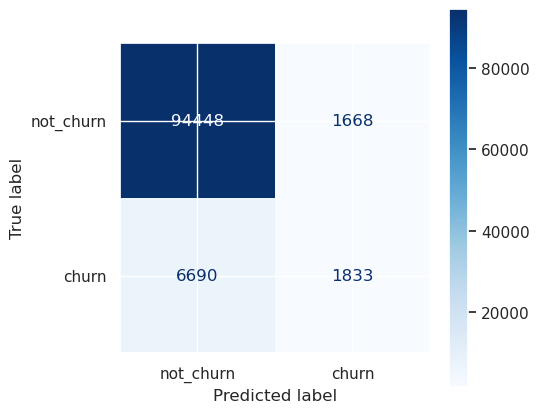

In [41]:
from sklearn.model_selection import StratifiedKFold
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_DH_SPESIAL 2021-12',
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]



skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    print("="*50)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]



    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)


    from imblearn.over_sampling import SMOTE
    oversampler = SMOTE(random_state=0)
    X_train ,y_train = oversampler.fit_resample(X_train, y_train)


    clf_ridge = RandomForestClassifier(n_jobs=32) 
    clf_ridge.fit(X_train, y_train) 
    # pred = clf_ridge.predict(X_test)
    pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)


    print(classification_report(y_test, pred))
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    display(ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                            cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                            ax = ax, values_format = 'd'))

### rf over oversampling 3/3

              precision    recall  f1-score   support

           0       0.98      0.97      0.97    101157
           1       0.29      0.34      0.31      3483

    accuracy                           0.95    104640
   macro avg       0.63      0.66      0.64    104640
weighted avg       0.95      0.95      0.95    104640



              precision    recall  f1-score   support

           0       0.98      0.98      0.98    101157
           1       0.34      0.30      0.32      3482

    accuracy                           0.96    104639
   macro avg       0.66      0.64      0.65    104639
weighted avg       0.95      0.96      0.96    104639



              precision    recall  f1-score   support

           0       0.98      0.96      0.97    101157
           1       0.26      0.36      0.30      3482

    accuracy                           0.94    104639
   macro avg       0.62      0.66      0.64    104639
weighted avg       0.95      0.94      0.95    104639



              precision    recall  f1-score   support

           0       0.98      0.89      0.93    101157
           1       0.12      0.45      0.19      3482

    accuracy                           0.87    104639
   macro avg       0.55      0.67      0.56    104639
weighted avg       0.95      0.87      0.91    104639



              precision    recall  f1-score   support

           0       0.97      1.00      0.98    101156
           1       0.45      0.06      0.11      3483

    accuracy                           0.97    104639
   macro avg       0.71      0.53      0.55    104639
weighted avg       0.95      0.97      0.95    104639



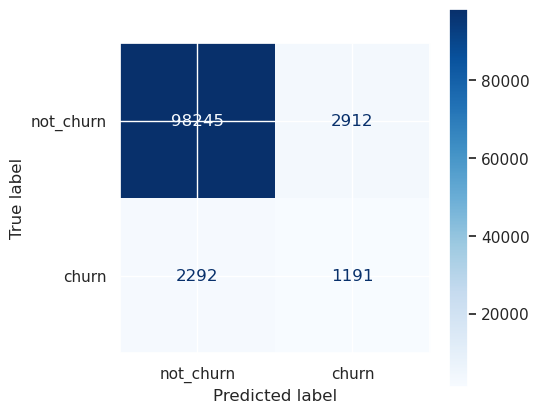

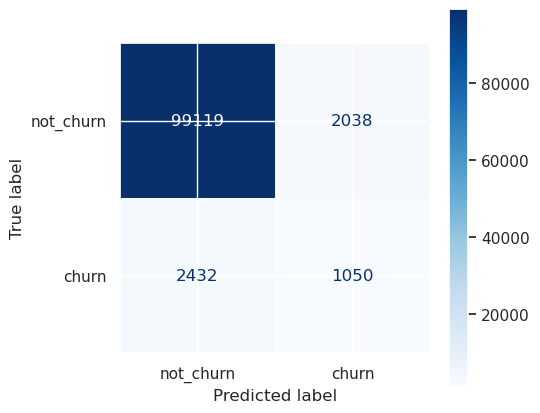

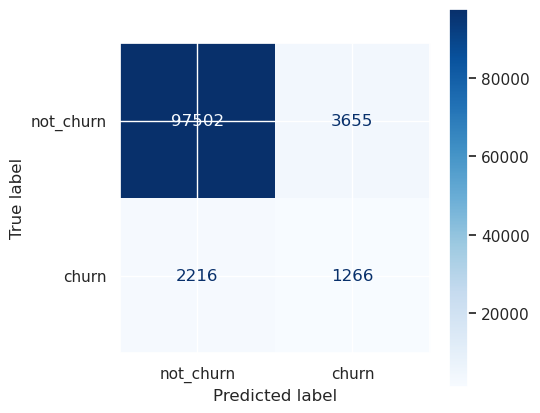

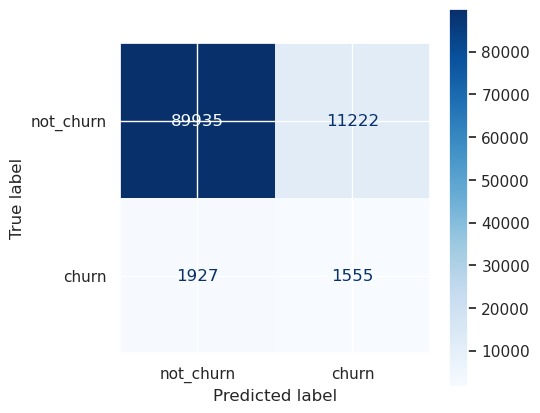

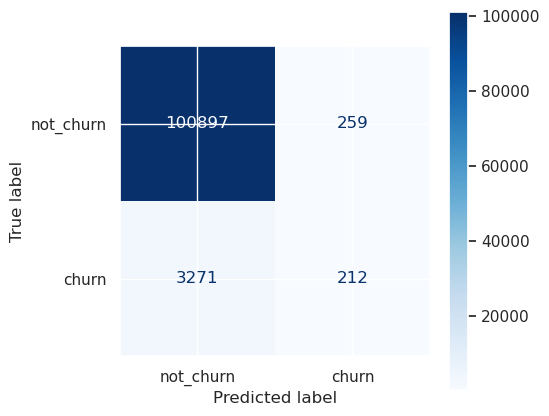

In [49]:
condition_3_3 = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition_3_3, 1, 0)

from sklearn.model_selection import StratifiedKFold



X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_DH_SPESIAL 2021-12',
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]



skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    print("="*50)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]



    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)


    from imblearn.over_sampling import SMOTE
    oversampler = SMOTE(random_state=0)
    X_train ,y_train = oversampler.fit_resample(X_train, y_train)


    clf_ridge = RandomForestClassifier(n_jobs=32) 
    clf_ridge.fit(X_train, y_train) 
    # pred = clf_ridge.predict(X_test)
    pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)


    print(classification_report(y_test, pred))
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    display(ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                            cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                            ax = ax, values_format = 'd'))

In [47]:
X.head()

,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_DH_SPESIAL 2021-09,TRO_DH_SPESIAL 2021-10,TRO_DH_SPESIAL 2021-11,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,SLA 2021-09,SLA 2021-10,SLA 2021-11,SLA_LATE 2021-09,SLA_LATE 2021-10,SLA_LATE 2021-11,TRO_VOUCHER_USAGE 2021-09,TRO_VOUCHER_USAGE 2021-10,TRO_VOUCHER_USAGE 2021-11,TRO_PAYMENT_METHOD 2021-09,TRO_PAYMENT_METHOD 2021-10,TRO_PAYMENT_METHOD 2021-11,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,PV 2021-09,PV 2021-10,PV 2021-11,SINCE_REGIS,NET 11-10,NET 10-09,NET 11-09,STRUK 11-10,STRUK 10-09,STRUK 11-09,PV 11-10,PV 10-09,PV 11-09,SLA 11-10,SLA 10-09,SLA 11-09
1,1791590.0,2412654.0,3117811.0,81500.0,109200.0,131400.0,20.0,35.0,49.0,217.1,480.8,630.1,0.0,1.0,0.0,0.0,0.0,200000.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,27.0,46.0,931.0,705157.0,621064.0,1326221.0,14.0,15.0,29.0,19.0,2.0,21.0,149.3,263.7,413.0
2,0.0,191267.0,0.0,0.0,70400.0,0.0,0.0,6.0,0.0,0.0,9951.7,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,743.0,-191267.0,191267.0,0.0,-6.0,6.0,0.0,-6.0,6.0,0.0,-9951.7,9951.7,0.0
3,202358.0,644400.0,165315.0,5200.0,14300.0,2200.0,4.0,10.0,3.0,73.3,214.9,93.3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,926.0,-479085.0,442042.0,-37043.0,-7.0,6.0,-1.0,-4.0,4.0,0.0,-121.5,141.6,20.0
4,0.0,0.0,412904.0,0.0,0.0,124100.0,0.0,0.0,4.0,0.0,0.0,34.6,0.0,0.0,0.0,0.0,0.0,10000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,760.0,412904.0,0.0,412904.0,4.0,0.0,4.0,1.0,0.0,1.0,34.6,0.0,34.6
5,48952.0,39453.0,65634.0,12900.0,6200.0,400.0,2.0,1.0,2.0,1868.2,437.0,11.3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,4.0,909.0,26181.0,-9499.0,16682.0,1.0,-1.0,0.0,4.0,-16.0,-12.0,-425.6,-1431.2,-1856.8


In [ ]:
df_res = pd.concat([
    pd.concat([df_tto_re_pv.drop(['label'],1).loc[X_test.index, :].reset_index(drop=True), pd.DataFrame({'pred':pred})],1), 
    y_test.reset_index(drop=True)],1)

In [ ]:
df_res[(df_res['label'] == 0) & (df_res['pred'] == 1)].head(10)

In [ ]:
df_res[(df_res['label'] == 1) & (df_res['pred'] == 0)].head(10)

## XGBOOST

### not oversampling 2/3

In [ ]:
from sklearn.model_selection import StratifiedKFold
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]


skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    print("="*50)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    
    ## applying standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)
    


    clf_ridge = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1)
    clf_ridge.fit(X_train, y_train) 
    pred = clf_ridge.predict(X_test)

    print(classification_report(y_test, pred))
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                            cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                            ax = ax, values_format = 'd')



In [ ]:
# condition_2_3 = (
# ((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
# ((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
# (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
# ((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
# (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-12'] == 0))
# )

# df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


# X = df_tto_re_pv.drop(
# [
# 'TRO_MEMBERS',
# 'TRO_NET 2021-12', 
# 'TRO_NO_ORDER 2021-12',
# 'SLA 2021-12',
# 'SLA_LATE 2021-12',
# 'RATING_BELOW 2021-12',
# 'RATING_AVG 2021-12',
# 'PV 2021-12',
# 'TRO_VOUCHER_USAGE 2021-12',
# 'TRO_PAYMENT_METHOD 2021-12',
# 'label'
# ], 1
# )
# y = df_tto_re_pv['label']


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
# X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)

# clf_ridge = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1)
# clf_ridge.fit(X_train, y_train) 
# # pred_proba = clf_ridge.predict_proba(X_test)
# pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
# print(classification_report(y_test, pred))
# fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
# ConfusionMatrixDisplay.from_predictions(y_test, pred, 
#                                         cmap='Blues', display_labels= ['not_churn', 'churn'], 
#                                         ax = ax, values_format = 'd')


### not oversampling version 3/3

In [ ]:
condition_3_3 = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition_3_3, 1, 0)

X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)

clf_ridge = RandomForestClassifier(random_state=42) 
clf_ridge.fit(X_train, y_train) 
# pred_proba = clf_ridge.predict_proba(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

## MLP ( 2/3 )

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     96117
           1       0.54      0.15      0.23      8523

    accuracy                           0.92    104640
   macro avg       0.73      0.57      0.59    104640
weighted avg       0.90      0.92      0.90    104640

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     96117
           1       0.58      0.06      0.10      8522

    accuracy                           0.92    104639
   macro avg       0.75      0.53      0.53    104639
weighted avg       0.89      0.92      0.89    104639

              precision    recall  f1-score   support

           0       0.93      0.98      0.96     96116
           1       0.50      0.22      0.31      8523

    accuracy                           0.92    104639
   macro avg       0.71      0.60      0.63    104639
weighted avg       0.90      0.92      0.90    104639

              preci

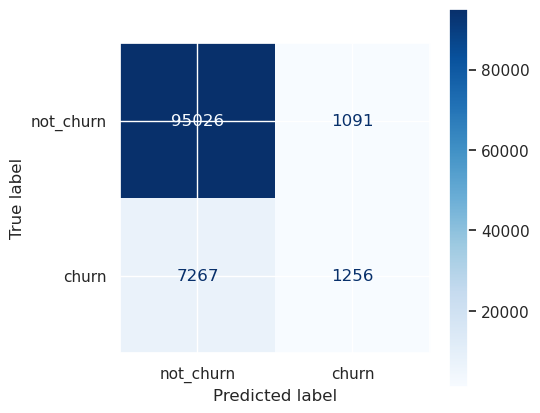

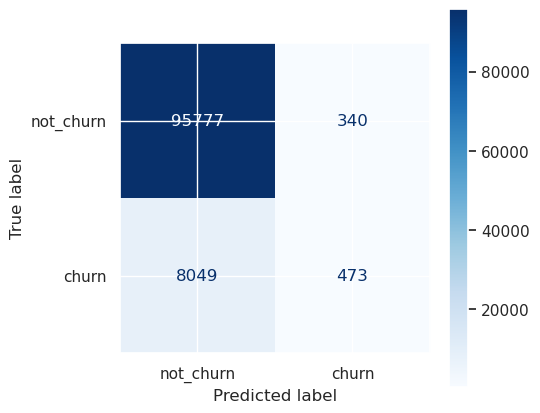

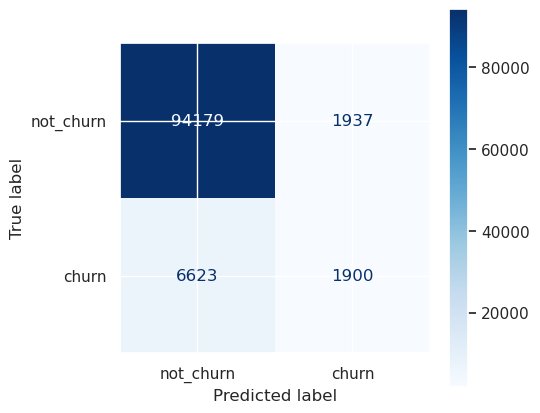

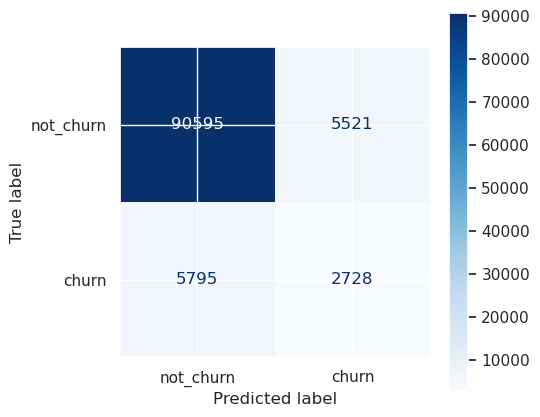

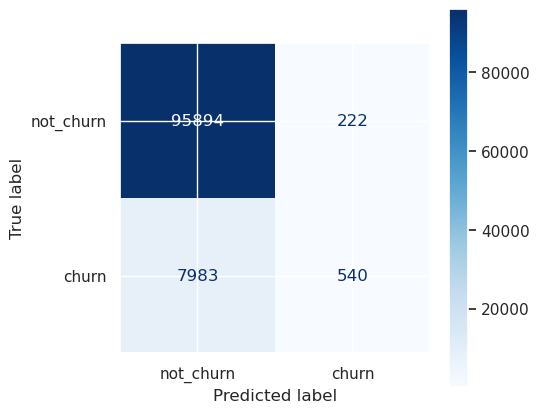

In [39]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_DH_SPESIAL 2021-12',
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]



skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    print("="*50)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)
    
    ## applying standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)
    

#     ## applying pca
#     n_comp = 5

#     pca = PCA(n_components=n_comp)
#     pca.fit(X_train)
#     X_train = pd.DataFrame(pca.transform(X_train), columns=(['col{}'.format(i) for i in range(1,n_comp+1)]))
#     X_test = pd.DataFrame(pca.transform(X_test), columns=(['col{}'.format(i) for i in range(1,n_comp+1)]))

    clf_ridge = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(15,))
#     clf_ridge = LinearSVC(C=0.01, penalty="l1", dual=False)
    clf_ridge.fit(X_train, y_train) 
    pred = clf_ridge.predict(X_test)
#     pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
    print(classification_report(y_test, pred))
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                            cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                            ax = ax, values_format = 'd')



In [ ]:
from sklearn.model_selection import StratifiedKFold
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]



skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    print("="*50)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    
    ## applying standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)
    


    clf_ridge = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(15,))
    clf_ridge.fit(X_train, y_train) 
    pred = clf_ridge.predict(X_test)

    print(classification_report(y_test, pred))
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                            cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                            ax = ax, values_format = 'd')



In [ ]:
condition_3_3 = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition_3_3, 1, 0)

X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_train.columns)

clf_ridge = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(30,))
clf_ridge.fit(X_train, y_train) 
# pred_proba = clf_ridge.predict_proba(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

## MLP 2/3 oversampling

In [ ]:
from sklearn.neural_network import MLPClassifier


condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-12'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'TRO_VOUCHER_USAGE 2021-12',
'TRO_PAYMENT_METHOD 2021-12',
'label'
], 1
)
y = df_tto_re_pv[['label']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

from imblearn.over_sampling import SMOTE
oversampler = SMOTE(random_state=0)
X_train ,y_train = oversampler.fit_resample(X_train, y_train)

clf_ridge = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(30,))
clf_ridge.fit(X_train, y_train) 



# pred = clf_ridge.predict(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

In [ ]:
condition = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition, 1, 0)

X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

clf_ridge = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(30,))
clf_ridge.fit(X_train, y_train) 

pred = clf_ridge.predict(X_test)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax, values_format = 'd')

## simple ruling (construct own)

In [ ]:

condition_3_3 = ( 
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-12'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition_3_3, 1, 0)




X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-12', 
'TRO_NO_ORDER 2021-12',
'SLA 2021-12',
'SLA_LATE 2021-12',
'RATING_BELOW 2021-12',
'RATING_AVG 2021-12',
'PV 2021-12',
'label'
], 1
)
y = df_tto_re_pv['label']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

condition_2_3 = (
((X_test['NET_11-10'] < 0) & \
(X_test['NET_10-09'] < 0) & \
(X_test['NET_11-09'] < 0)
)
)

pred = np.where(condition_2_3, 1, 0)




print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

In [ ]:
a = pd.DataFrame()
a['NET_12-11'] = df_tto_re_pv['TRO_NET 2021-12'] - df_tto_re_pv['TRO_NET 2021-11']
a['NET_11-10'] = df_tto_re_pv['TRO_NET 2021-11'] - df_tto_re_pv['TRO_NET 2021-10']
a['NET_12-10'] = df_tto_re_pv['TRO_NET 2021-12'] - df_tto_re_pv['TRO_NET 2021-10']

a['STRUK_12-11'] = df_tto_re_pv['TRO_NO_ORDER 2021-12'] - df_tto_re_pv['TRO_NO_ORDER 2021-11']
a['STRUK_11-10'] = df_tto_re_pv['TRO_NO_ORDER 2021-11'] - df_tto_re_pv['TRO_NO_ORDER 2021-10']
a['STRUK_12-10'] = df_tto_re_pv['TRO_NO_ORDER 2021-12'] - df_tto_re_pv['TRO_NO_ORDER 2021-10']

In [ ]:
X_12 = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-09', 
'TRO_NO_ORDER 2021-09',
'SLA 2021-09',
'SLA_LATE 2021-09',
'RATING_BELOW 2021-09',
'RATING_AVG 2021-09',
'PV 2021-09',
'label'
], 1
)
X_12 = pd.concat([X_12.iloc[:,0:-6],a],1)
y_12 = df_tto_re_pv['label']

In [ ]:
X_12_scale = pd.DataFrame(scaler.transform(X_12), index=X_12.index, columns=X_12.columns)
pred = (clf_ridge.predict_proba(X_12_scale)[:,1] >= 0.5).astype(int)

In [ ]:
pd.Series(pred).value_counts()